In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils, backend, callbacks

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import awkward as ak
import uproot

from datetime import datetime

print(tf.config.list_physical_devices('GPU'))

2024-02-01 13:19:57.019842: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-01 13:19:57.614944: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 13:19:59.448477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-01 13:20:04.442430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 13:20:04.481149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 13:20:04.481208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
def sequentialDNNMaker(input_shape=None, output_shape=2, layer_sizes=(100, 100, 100), dropout=0, **kwargs):
    _model = keras.Sequential()  
    _model.add(keras.Input(shape=input_shape, name="input"))
    #_model.add(layers.Flatten(input_shape=input_shape, name="flatten"))
    for i, size in enumerate(layer_sizes):
        _layer_name = f"hidden_dense_{i}"
        #_layer = layers.Dense(size, name=_layer_name, kernel_initializer="he_uniform", kernel_regularizer=keras.regularizers.L1L2(l2=1e-2))
        _model.add(layers.Dense(size, name=_layer_name, kernel_initializer="he_uniform"))
        _model.add(layers.Activation("relu", name=_layer_name+"_activation"))
        if(dropout > 0):
            _model.add(layers.Dropout(dropout, name=_layer_name+"_dropout"))

    _layer_name = f"output_dense"
    _model.add(layers.Dense(output_shape, name=_layer_name))
    _model.add(layers.Activation("softmax", name=_layer_name+"_activation"))
    
    return _model

def functionalDNNMaker(input_shape=None, output_shape=2, layer_sizes=(100, 100, 100), dropout=0, **kwargs):
    _tensors = []
    _tensors.append(layers.Flatten(input_shape=input_shape, name="input"))
    for i, size in enumerate(layer_sizes):
        _layer_name = f"hidden_dense_{i}"
        _layer = layers.Dense(size, name=_layer_name, kernel_initializer="he_uniform")
        _activation = layers.Activation("relu", name=_layer_name+"_activation")
        
        _tensors.append(_layer(_tensors[-1]))
        _tensors.append(_activation(_tensors[-1]))
        if(dropout > 0):
            _dropout = layers.Dropout(0.5, name=_layer_name+"_dropout")
            _tensors.append(_dropout(_tensors[-1]))

    _layer_name = f"output_dense"
    _output_layer = layers.Dense(output_shape, name=_layer_name)
    _output_activation = layers.Activation("softmax", name=_layer_name+"_activation")
    _tensors.append(_output_layer(_tensors[-1]))
    _tensors.append(_output_activation(_tensors[-1]))
    
    _model = keras.Model(inputs=_tensors[0], outputs=_tensors[-1])
    
    return _model

In [3]:
features = ["pt", "eta", "phi", "nCharged", "girth", "ptd", "lesub", "wt"]
featuresNoWt = ["pt", "eta", "phi", "nCharged", "girth", "ptd", "lesub"]
#features = ["pt", "nCharged", "girth", "ptd", "lesub", "wt"]
#featuresNoWt = ["pt", "nCharged", "girth", "ptd", "lesub"]
columns = ["_"+feature for feature in features]

print("reading in matches...")
matchTree = uproot.open("inputFiles/embedding/embeddingNtuples_20231103_161545.root:matches")

print("getting gen matches as array...")
genMatchDf  = matchTree["genJet"].arrays(columns, library="pd")
genMatchDf.columns = features
print("getting reco matches as array...")
recoMatchDf = matchTree["recoJet"].arrays(columns, library="pd")
recoMatchDf.columns = features

print("matched jets: \n", genMatchDf.shape, "\n", recoMatchDf.shape)

jetPtMax = 40

jetPtFilter = (recoMatchDf["pt"] < jetPtMax) & (genMatchDf["pt"] < jetPtMax)

recoMatchDf = recoMatchDf.loc[jetPtFilter]
genMatchDf = genMatchDf.loc[jetPtFilter]

print("matched jets after selection: \n", genMatchDf.shape, "\n", recoMatchDf.shape)

testSize = 0.2

trainGen, testGen, trainReco, testReco = train_test_split(genMatchDf, recoMatchDf, test_size=testSize)
    
print("train-test split Gen: ", trainGen.shape, testGen.shape)
print("train-test split Reco: ", trainReco.shape, testReco.shape)

trainWts = trainGen["wt"]
trainWts = trainWts/trainWts.mean()
print("Sum of training weights: ", trainWts.sum())

testWts = testGen["wt"]
testWts = testWts/testWts.mean()
testGen["wt"] = testWts
testReco["wt"] = testWts
print("Sum of testing weights: ", testWts.sum())

scaler = StandardScaler()

X_det = scaler.fit_transform((pd.concat([testReco[featuresNoWt], trainReco[featuresNoWt]], ignore_index=True, sort=False)))
X_gen = scaler.fit_transform((pd.concat([trainGen[featuresNoWt], trainGen[featuresNoWt]], ignore_index=True, sort=False)))

Y_det = tf.keras.utils.to_categorical(np.concatenate((np.ones(testReco.shape[0]), np.zeros(trainReco.shape[0]))))
Y_gen = tf.keras.utils.to_categorical(np.concatenate((np.ones(trainGen.shape[0]), np.zeros(trainGen.shape[0]))))

print("training detector-level input shapes: ", X_det.shape, Y_det.shape)
print("training generator-level input shapes: ", X_gen.shape, Y_gen.shape)

reading in matches...
getting gen matches as array...
getting reco matches as array...
matched jets: 
 (2177154, 8) 
 (2177154, 8)
matched jets after selection: 
 (1575784, 8) 
 (1575784, 8)
train-test split Gen:  (1260627, 8) (315157, 8)
train-test split Reco:  (1260627, 8) (315157, 8)
Sum of training weights:  1260627.0
Sum of testing weights:  315156.99999999994
training detector-level input shapes:  (1575784, 7) (1575784, 2)
training generator-level input shapes:  (2521254, 7) (2521254, 2)


In [5]:
print(Y_det[-1])

[1. 0.]


315156.9999999998 315156.99999999994
315156.99999999994 1260627.0


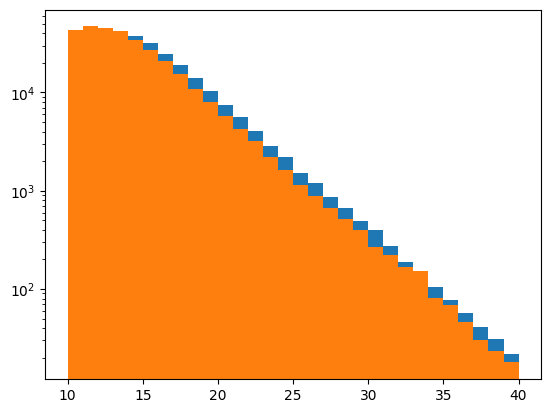

In [6]:
# reweight the sim and data to have the same total weight to begin with
nData, nEmbedding = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])

#wData = np.ones(nData)
#wEmbedding = nData/float(nEmbedding)*np.ones(nEmbedding)

wData = testWts.to_numpy()
wEmbedding = (np.sum(wData)/trainWts.sum()*trainWts).to_numpy()

print(np.sum(wEmbedding), np.sum(wData))
print(np.sum(testWts), np.sum(trainWts))

plt.hist(trainGen["pt"], bins=30, weights=wEmbedding)
plt.hist(trainReco["pt"], bins=30, weights=wEmbedding)

plt.yscale("log")

now = datetime.now()
nownow = now.strftime("%d-%m-%Y_%H-%M-%S")
folderPath = "savedModels/savedModel_"+nownow
unfoldingWeightsFilename = f"{folderPath}/unfoldingWeights"
#logdir = "logs/"+nownow

lossFunc="categorical_crossentropy"
optimizer="adam"
metricList=["accuracy"]
#weightedMetricList = ["categorical_crossentropy"]
weightedMetricList = []

patience=5

validationSize = 0.2
nEpochs = 150
batchSize = 2048

inputShape = X_det.shape[1:]

det_history = []
gen_history = []
w_sim = [wEmbedding]
nIter = 10

weightClipMin = 0.
weightClipMax = np.inf

In [ ]:
for i in range(nIter):
    detModel = sequentialDNNMaker(input_shape=inputShape)
    detModel.compile(loss=lossFunc, optimizer=optimizer, metrics=metricList, weighted_metrics=weightedMetricList)
    detCallBacks = [callbacks.EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)]
    detModelFilePath = folderPath + f"/step1_iteration{i}"+"_epoch{epoch}"
    detCallBacks.append(callbacks.ModelCheckpoint(detModelFilePath, save_best_only=True, verbose=1))
    #detCallBacks.append(callbacks.TensorBoard(log_dir=logdir, histogram_freq=1))

    genModel = sequentialDNNMaker(input_shape=inputShape)
    genModel.compile(loss=lossFunc, optimizer=optimizer, metrics=metricList, weighted_metrics=weightedMetricList)
    genCallBacks = [callbacks.EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)]
    genModelFilePath = folderPath + f"/step2_iteration{i}"+"_epoch{epoch}"
    genCallBacks.append(callbacks.ModelCheckpoint(genModelFilePath, save_best_only=True, verbose=1))
    #genCallBacks.append(callbacks.TensorBoard(log_dir=logdir, histogram_freq=1))

    if(i > 0):
        detModel.load_weights(folderPath + f"/step1_iteration{i-1}")
        genModel.load_weights(folderPath + f"/step2_iteration{i-1}")

    w_det = np.concatenate([wData, w_sim[-1]])
    
    X_det_train, X_det_val, Y_det_train, Y_det_val, w_det_train, w_det_val = train_test_split(X_det, Y_det, w_det, test_size=validationSize)
    detModel.summary()
    det_history.append(detModel.fit(X_det_train, Y_det_train, sample_weight=w_det_train, epochs=nEpochs, batch_size=batchSize, validation_data=(X_det_val, Y_det_val, w_det_val), verbose=1, callbacks=detCallBacks))
    detModel.save_weights(folderPath + f"/step1_iteration{i}")
    
    prediction = detModel.predict(X_det, batch_size=batchSize*10)
    scaleFactors = prediction[Y_det[:, 0] == 1]

    _pull = np.clip(scaleFactors[:, 1]/(scaleFactors[:, 0]+ 10**-50), weightClipMin, weightClipMax)*w_sim[-1]
    w_sim.append(_pull)

    w_gen = np.concatenate([w_sim[-1], w_sim[-2]])
    
    X_gen_train, X_gen_val, Y_gen_train, Y_gen_val, w_gen_train, w_gen_val = train_test_split(X_gen, Y_gen, w_gen, test_size=validationSize)
    genModel.summary()
    gen_history.append(genModel.fit(X_gen_train, Y_gen_train, sample_weight=w_gen_train, epochs=nEpochs, batch_size=5*batchSize, validation_data=(X_gen_val, Y_gen_val, w_gen_val), verbose=1, callbacks=genCallBacks))
    genModel.save_weights(folderPath + f"/step2_iteration{i}")
    
    prediction = genModel.predict(X_gen, batch_size=batchSize*50)
    scaleFactors = prediction[Y_gen[:, 0] == 1]

    _push = np.clip(scaleFactors[:, 1]/(scaleFactors[:, 0]+ 10**-50), weightClipMin, weightClipMax)*w_sim[-1]
    w_sim.append(_push)
    
    np.save(unfoldingWeightsFilename, w_sim)

#filename = f"outputs/multifoldClosure_{patience}_{batchSize}_{nEpochs}_{nIter}_{nownow}.root"
#outFile = uproot.recreate(filename)
#print("Saving to file: ", filename)

#trainGen["wt"] = w_sim[2*nIter]
#outFile["unfolded"] = trainGen
#outFile["reco"] = testReco
#outFile["gen"] = testGen
wu=w_sim

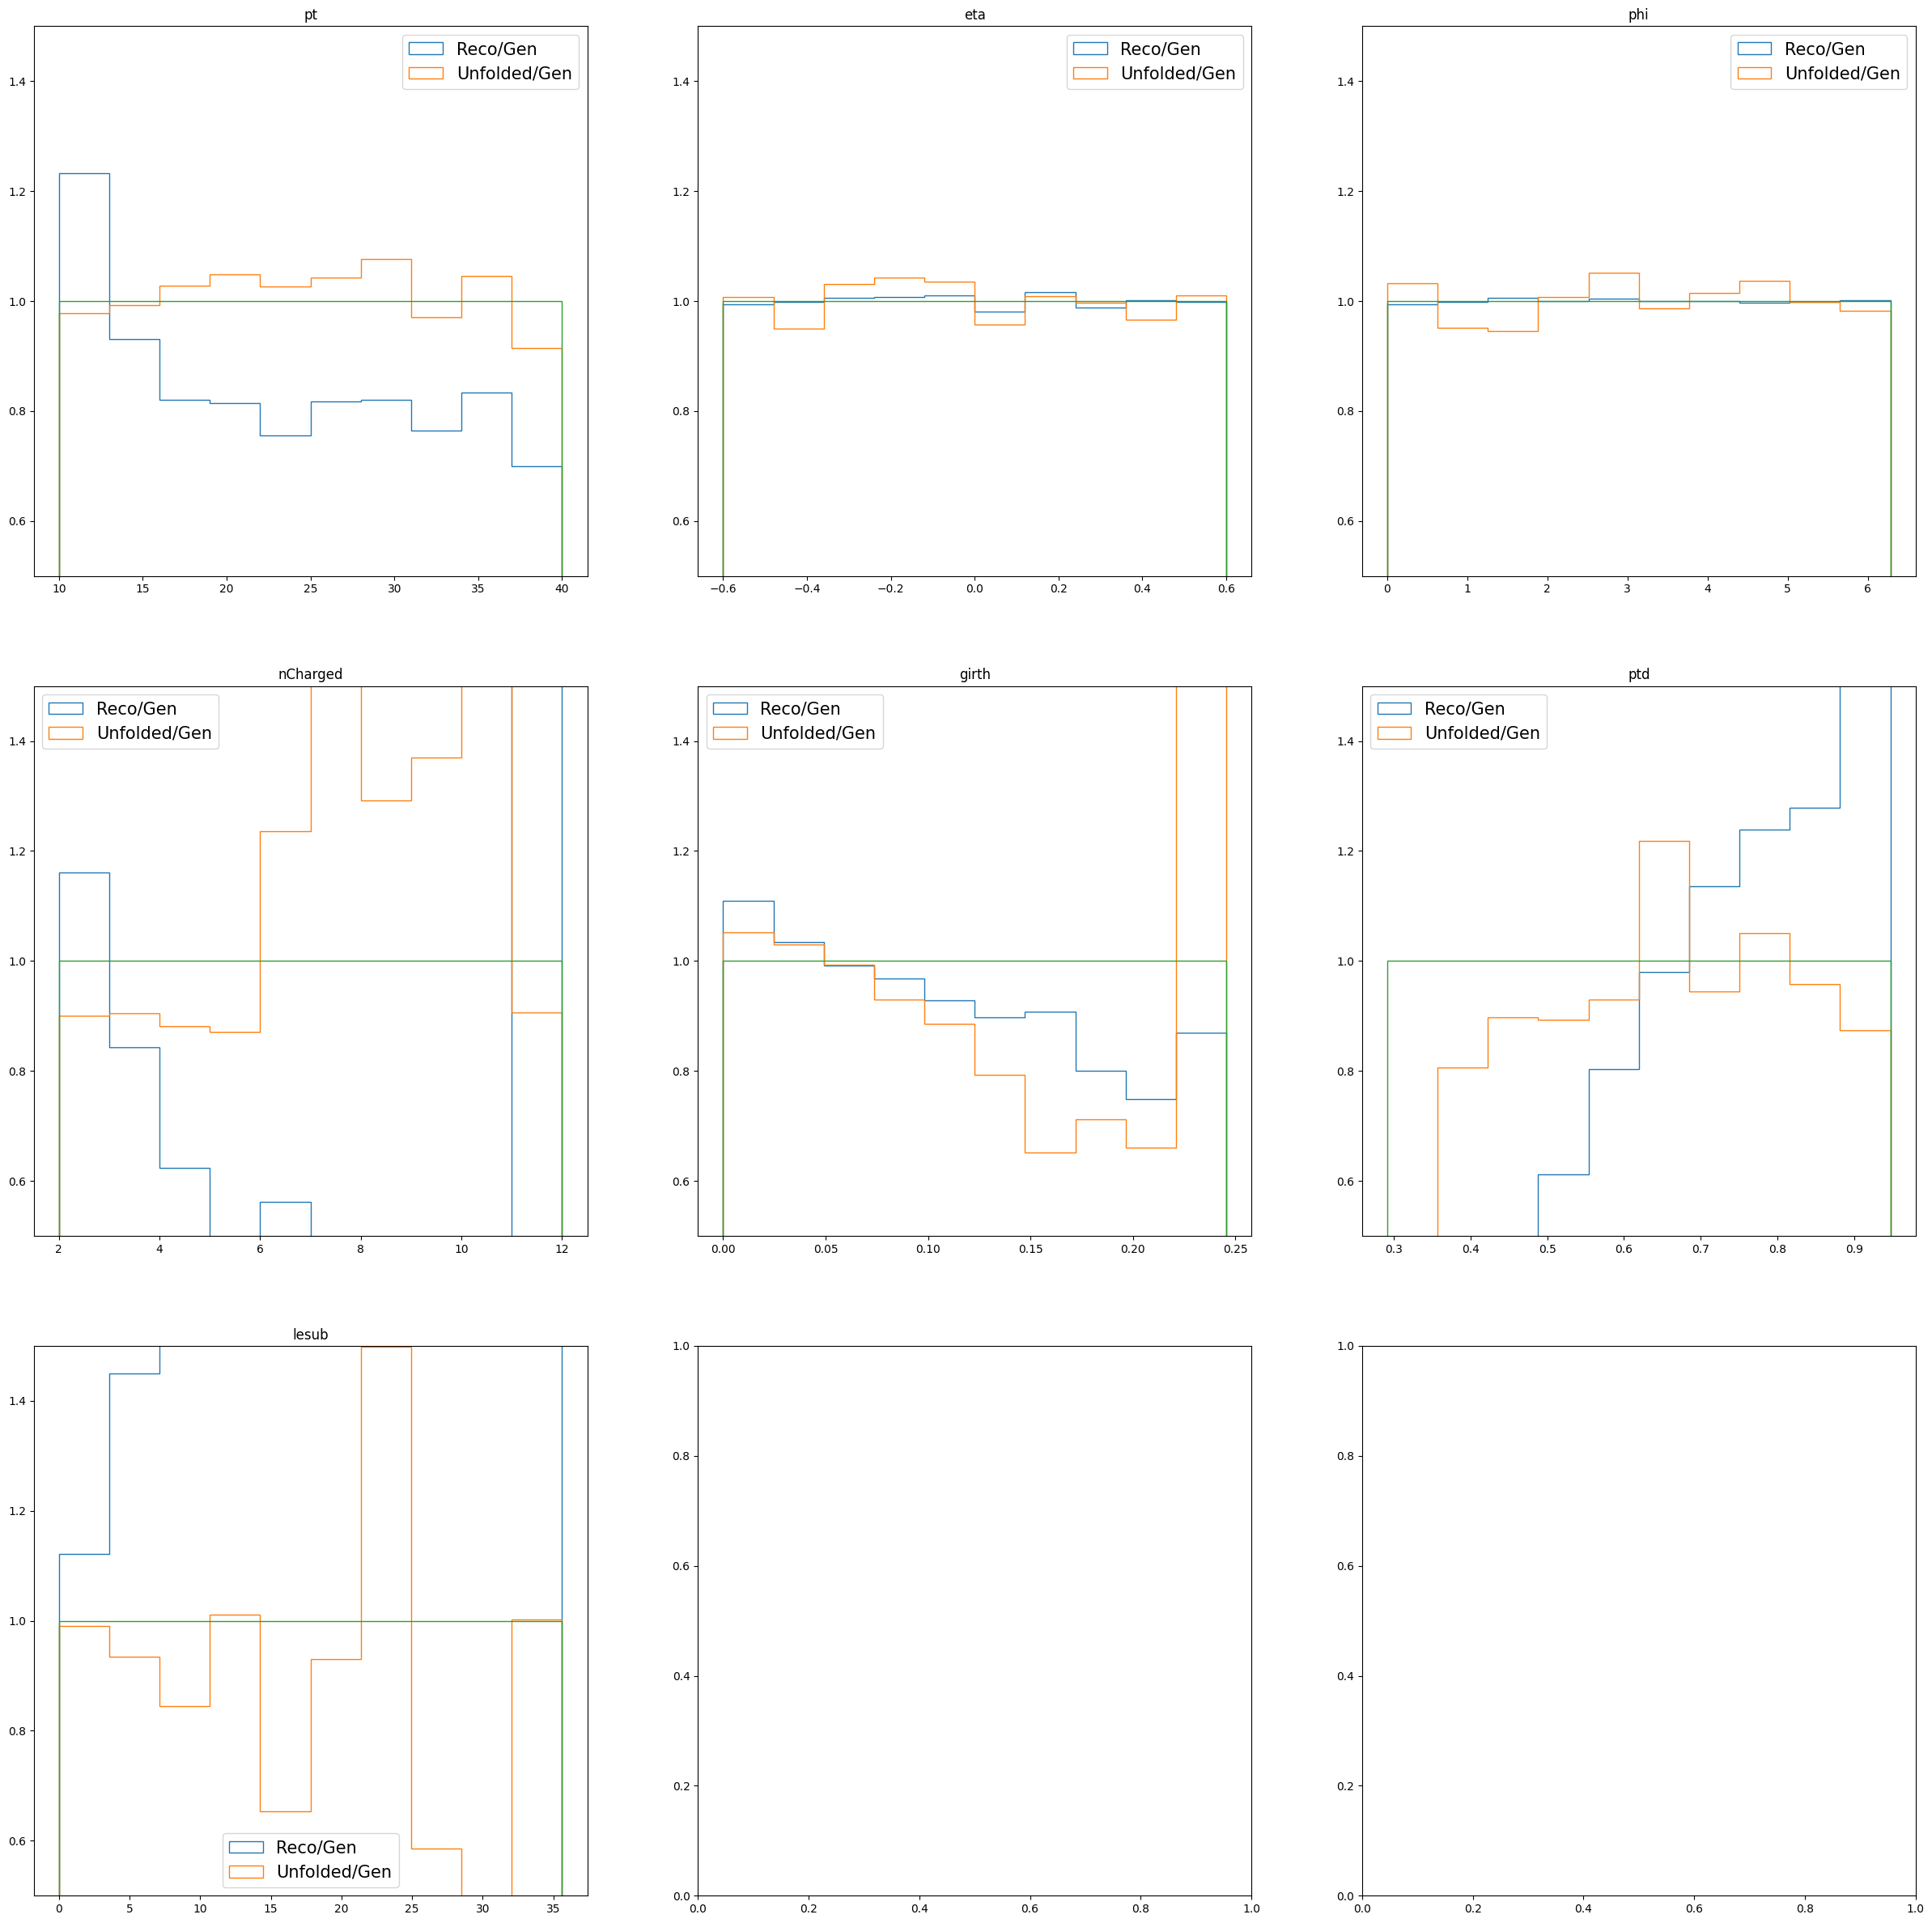

In [60]:
_iter = 6
nRows = 3
nColumns = 3
fig, ax = plt.subplots(nRows, nColumns, figsize=(30., 30.))
for i, feature in enumerate(featuresNoWt):
    row = int(i/nColumns)
    column = i%nColumns 
        
    histGen, bins = np.histogram(testGen[feature], weights=wData, density=True)
    histReco, bins = np.histogram(testReco[feature], weights=wData, density=True) 
    histUnfolded, bins = np.histogram(trainGen[feature], weights=wu[2*_iter], density=True)
        
    ax[row, column].hist(bins[:-1], bins, weights=histReco/histGen, label="Reco/Gen", histtype="step")
    ax[row, column].hist(bins[:-1], bins, weights=histUnfolded/histGen, label="Unfolded/Gen", histtype="step")
    ax[row, column].hist(bins[:-1], bins, weights=np.ones((bins.shape[0]-1)), histtype="step")
    ax[row, column].set_title(feature)
    ax[row, column].set_ylim(0.5, 1.5)
    ax[row, column].legend(prop={'size': 15})
        

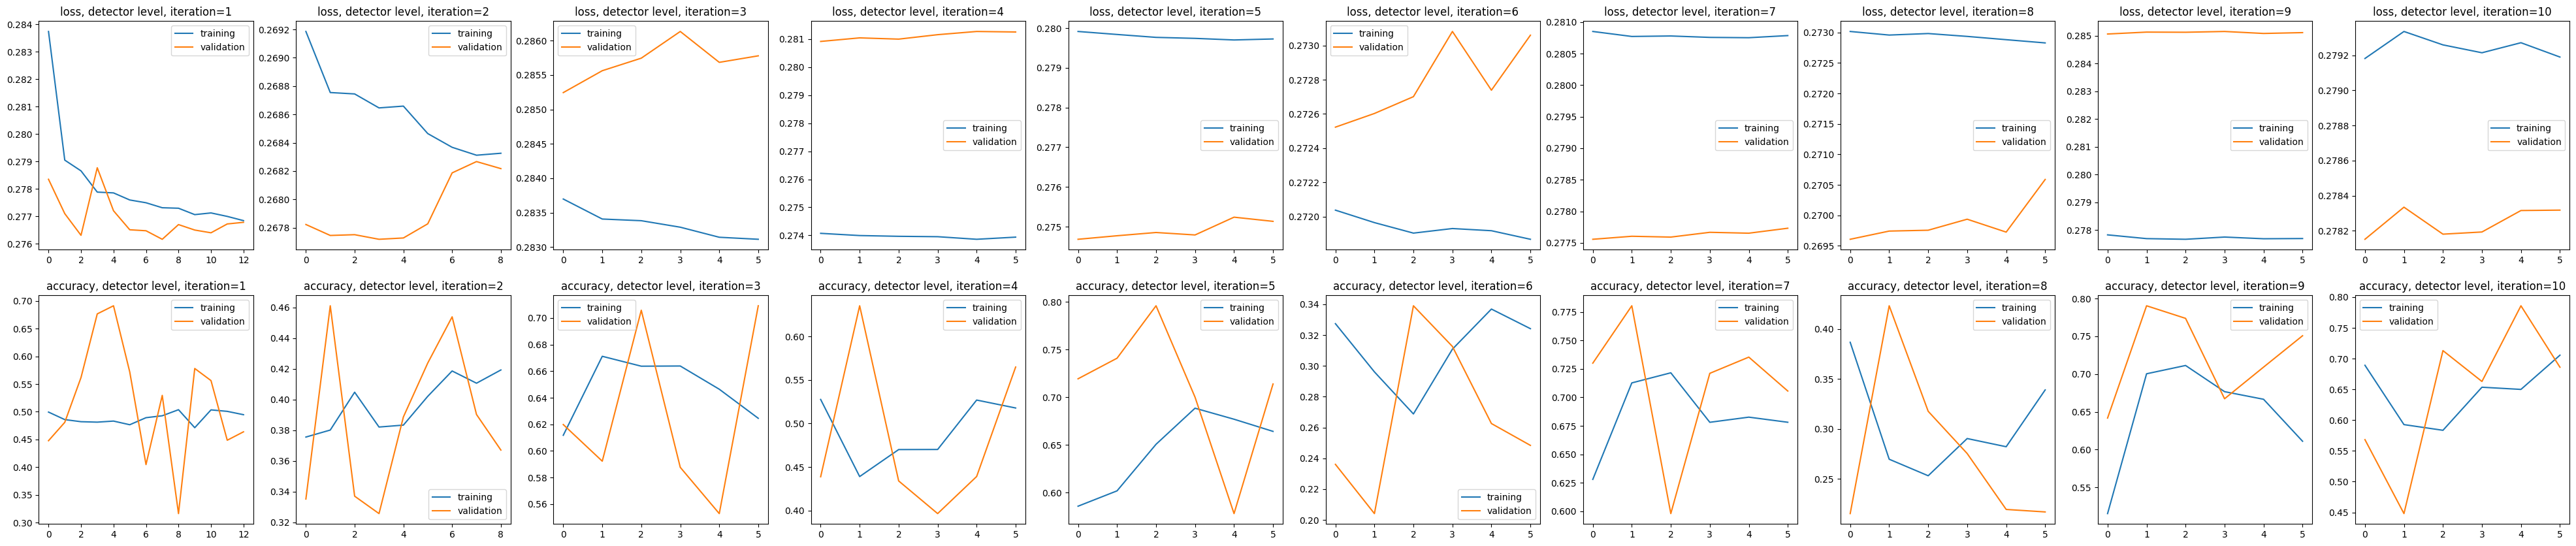

In [61]:
_nIter = 10

#metrics = ["loss", "accuracy", "categorical_crossentropy"]
metrics = ["loss", "accuracy"]
detfig, detax = plt.subplots(len(metrics), _nIter, figsize=(_nIter*5., len(metrics)*5.))
for row, metricName in enumerate(metrics):
    for column in range(_nIter):
        detax[row, column].plot(det_history[column].history[metricName], label="training")
        detax[row, column].plot(det_history[column].history["val_"+metricName], label="validation")
        detax[row, column].set_title(metricName+f", detector level, iteration={column+1}")
        #detax[row, column].set_ylim(0.25, 0.32)
        detax[row, column].legend()

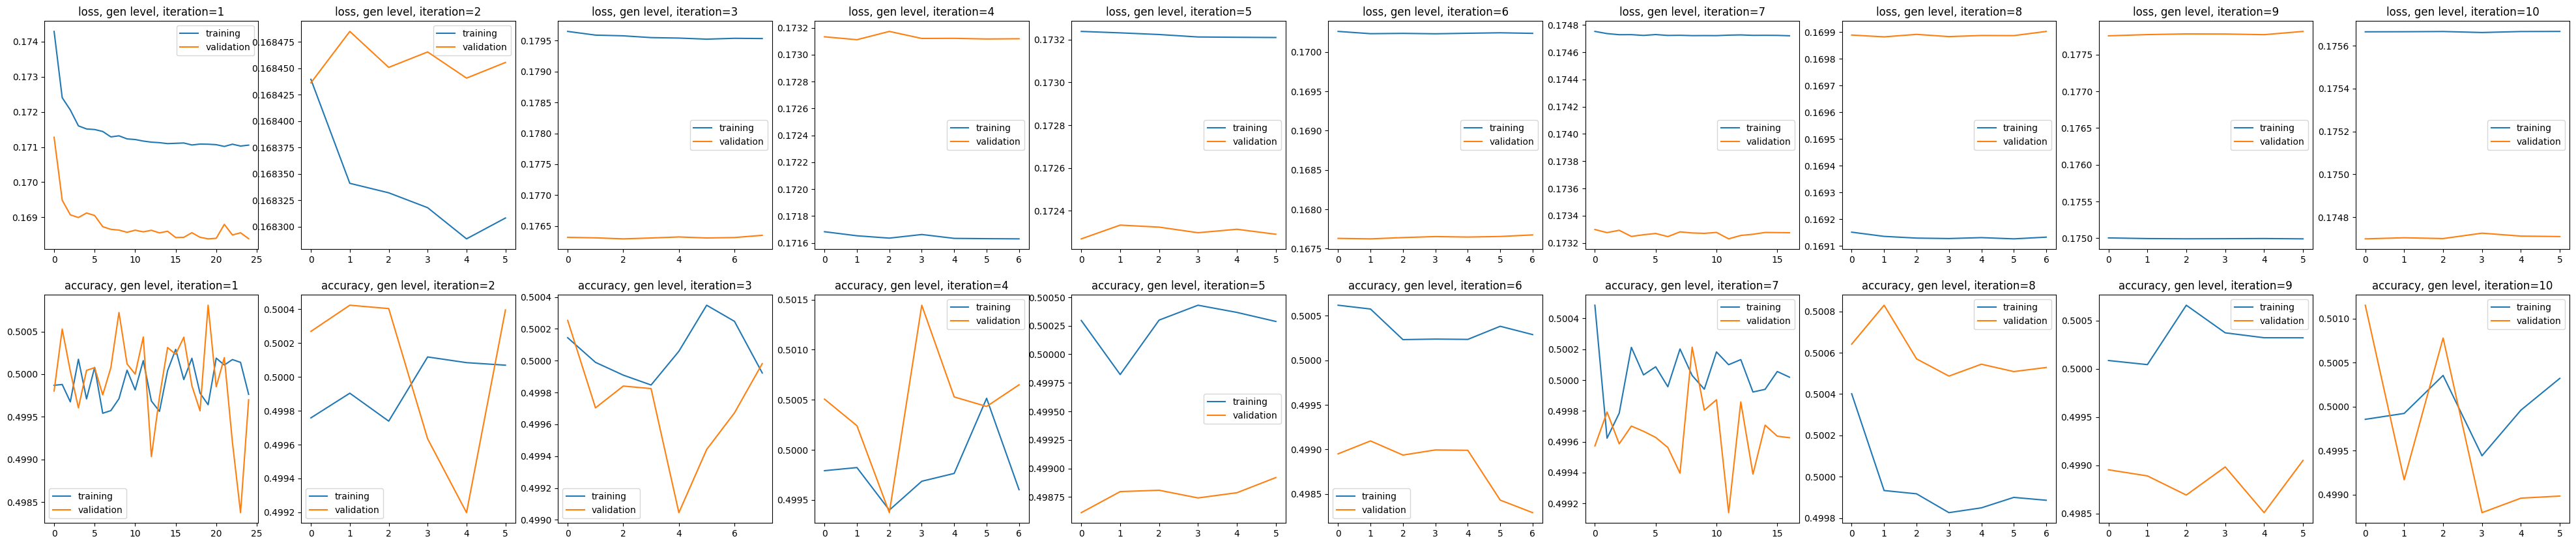

In [62]:
genfig, genax = plt.subplots(len(metrics), _nIter, figsize=(_nIter*5., len(metrics)*5.))
for row, metricName in enumerate(metrics):
    for column in range(_nIter):
        genax[row, column].plot(gen_history[column].history[metricName], label="training")
        genax[row, column].plot(gen_history[column].history["val_"+metricName], label="validation")
        genax[row, column].set_title(metricName+f", gen level, iteration={column+1}")
        genax[row, column].legend()

In [54]:
print(det_history[0].history)

{'loss': [0.278911828994751, 0.2776157557964325, 0.2773491442203522, 0.27727794647216797, 0.2772413492202759, 0.277217298746109, 0.2771912217140198, 0.27718186378479004, 0.27717116475105286, 0.27716001868247986, 0.277161568403244, 0.27714860439300537, 0.2771391272544861, 0.27714601159095764, 0.27713948488235474, 0.2771207392215729, 0.27711308002471924], 'accuracy': [0.5001764893531799, 0.5000551342964172, 0.5049391984939575, 0.509109377861023, 0.5078417062759399, 0.5049907565116882, 0.507415771484375, 0.5162946581840515, 0.5001709461212158, 0.5022262930870056, 0.5125457644462585, 0.5147755742073059, 0.5134944915771484, 0.5242795944213867, 0.51663738489151, 0.5230135321617126, 0.5154101848602295], 'val_loss': [0.2783079445362091, 0.2778560519218445, 0.2777407765388489, 0.27779456973075867, 0.27771157026290894, 0.27769699692726135, 0.27762964367866516, 0.2776433527469635, 0.2776465117931366, 0.2776500880718231, 0.27765268087387085, 0.27760717272758484, 0.27769532799720764, 0.277636766433